In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import projected_evolution_dynamics as me
import matrix_analysis_lib as mat_ansys
import spin_representations as su2
import evs_visualization_tools as evs_visz_tools
import Hierarchical_Basis_Evs as HBProjEv

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

In [20]:
N=3; chain_type = "XX"; k_B = 1; temp = 1e-1; temp_ref = 2e-1

### Construcción de los operadores
spin_ops_list = su2.one_body_spin_ops(N)
identity_op = spin_ops_list[0][0]
ts = np.linspace(0, 5.,500)  

### Heisenberg Hamiltonian
Hamiltonian_paras = [-.5, -.25, 0., .1]#.3]
H_H = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### classical operators 

cl_ops, label_ops = su2.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
cl_ops["Delta_n^2"] = cl_ops["n_oc_op"]**2; label_ops.append("Delta_n^2")
print("Are all the operators Hermitian?:", mat_ansys.basis_hermitian_check(cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True, True]


In [21]:
ts = np.linspace(0, 2.0,500)  

beta_ref = (1/temp_ref); coeff_lambda = .5
#K_ref = - beta_ref * .5 * H_H - coeff_lambda * (cl_ops["n_oc_op"]-1)**2
K_ref = -beta_ref ** .5 * spin_ops_list[1][0] #- coeff_lambda * (cl_ops["n_oc_op"]-1)**2
rho_ref = (K_ref).expm()
custom_rho_ref = rho_ref/rho_ref.tr()
assert mat_ansys.is_density_op(custom_rho_ref), "Reference state not a density operator"

range_derived_series_orders = [1, 3, 5] #1,2]
all_coeff_lists = [[.0, .0, .0, .3] + 
                   [0 for i in range(range_derived_series_orders[k])] for k in range(len(range_derived_series_orders))]
fixed_ops_list = [identity_op, H_H, cl_ops["n_oc_op"]]

In [22]:
# solo algunos observables
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op"] = cl_ops["x_op"]; subset_label_ops.append("x_op")
subset_of_observables["x_op_sq"] = cl_ops["x_op"]**2; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")
#subset_of_observables["magnetization"] = cl_ops["magnetization"]; subset_label_ops.append("magnetization")

Processing step:  1  and hierarchical basis of l=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  5
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynamics Succesfully Concluded.
    |▼| 6b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of l=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  7
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. Check passed: phi0 and basis_orth have the same cardinalities.
    |▼| 5. ProjEv Dynam

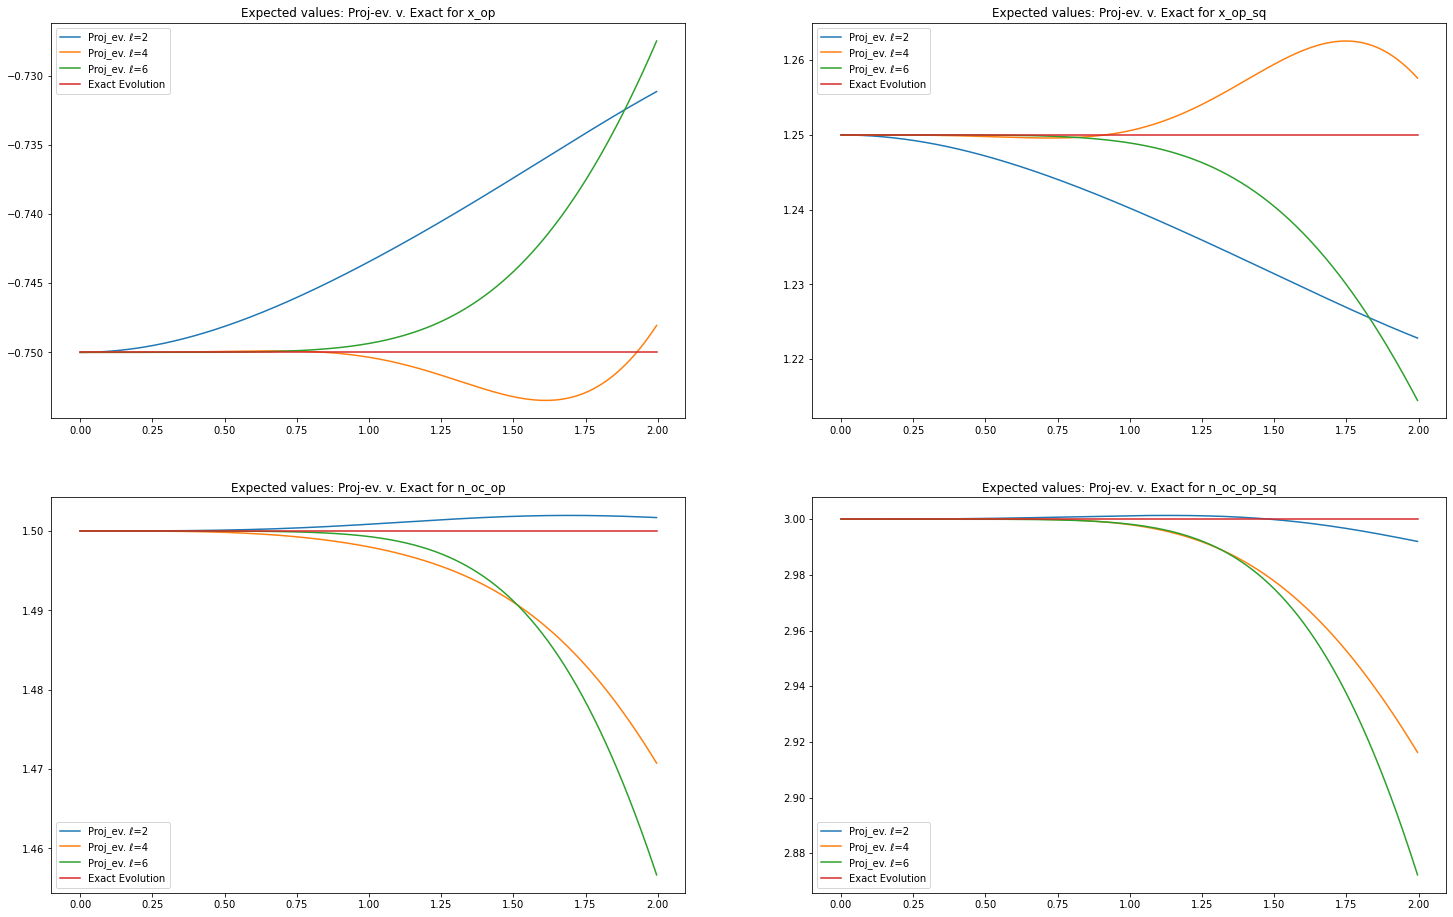

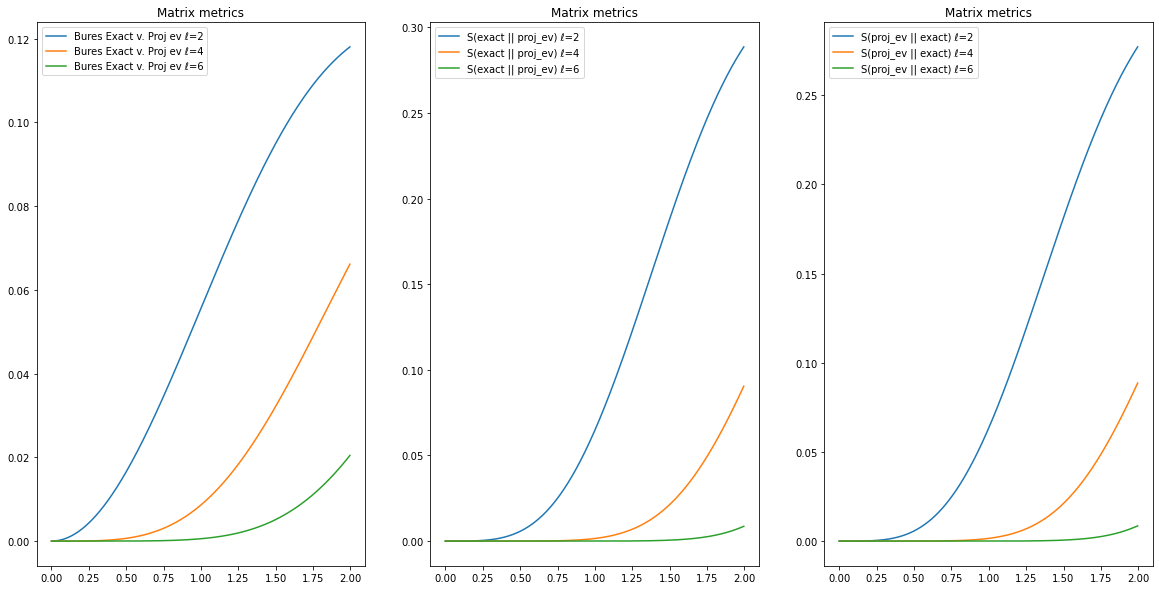

In [23]:
# N = 2, XX
resultados = HBProjEv.HierarchBasis_vardim_proj_evs(Hamiltonian = H_H, fixed_ops_list = fixed_ops_list,
                                                    rho_ref = custom_rho_ref, 
                                              range_derived_series_orders = range_derived_series_orders, 
                                     temp_ref = temp_ref, temp_rho = temp,
                                     generating_operator = spin_ops_list[1][0],
                                     init_coeff_list = all_coeff_lists,
                                     timespan = ts, label_ops = subset_label_ops,
                                     observables = list(subset_of_observables.values()))

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                                 plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = range_derived_series_orders,
                                                                  multiple_evolutions = resultados,
                                                           plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = range_derived_series_orders,
                                                     metric_local = metrics,
                                                    plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

Processing step:  1  and hierarchical basis of l=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  4
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. ProjEv Dynamics Succesfully Concluded.
    |▼| 5b. Exact Dynamics not to be computed. Skipped.
    |▼| 5b. No Plots to process.
    |▼| 6. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of l=  3
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  6
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. ProjEv Dynamics Succesfully Concluded.
    |▼| 5b. Exact Dynamics not to be computed. Skipped.
    |▼| 5b. No Plots to process.
    |▼| 6. Data Stored. Evolutio

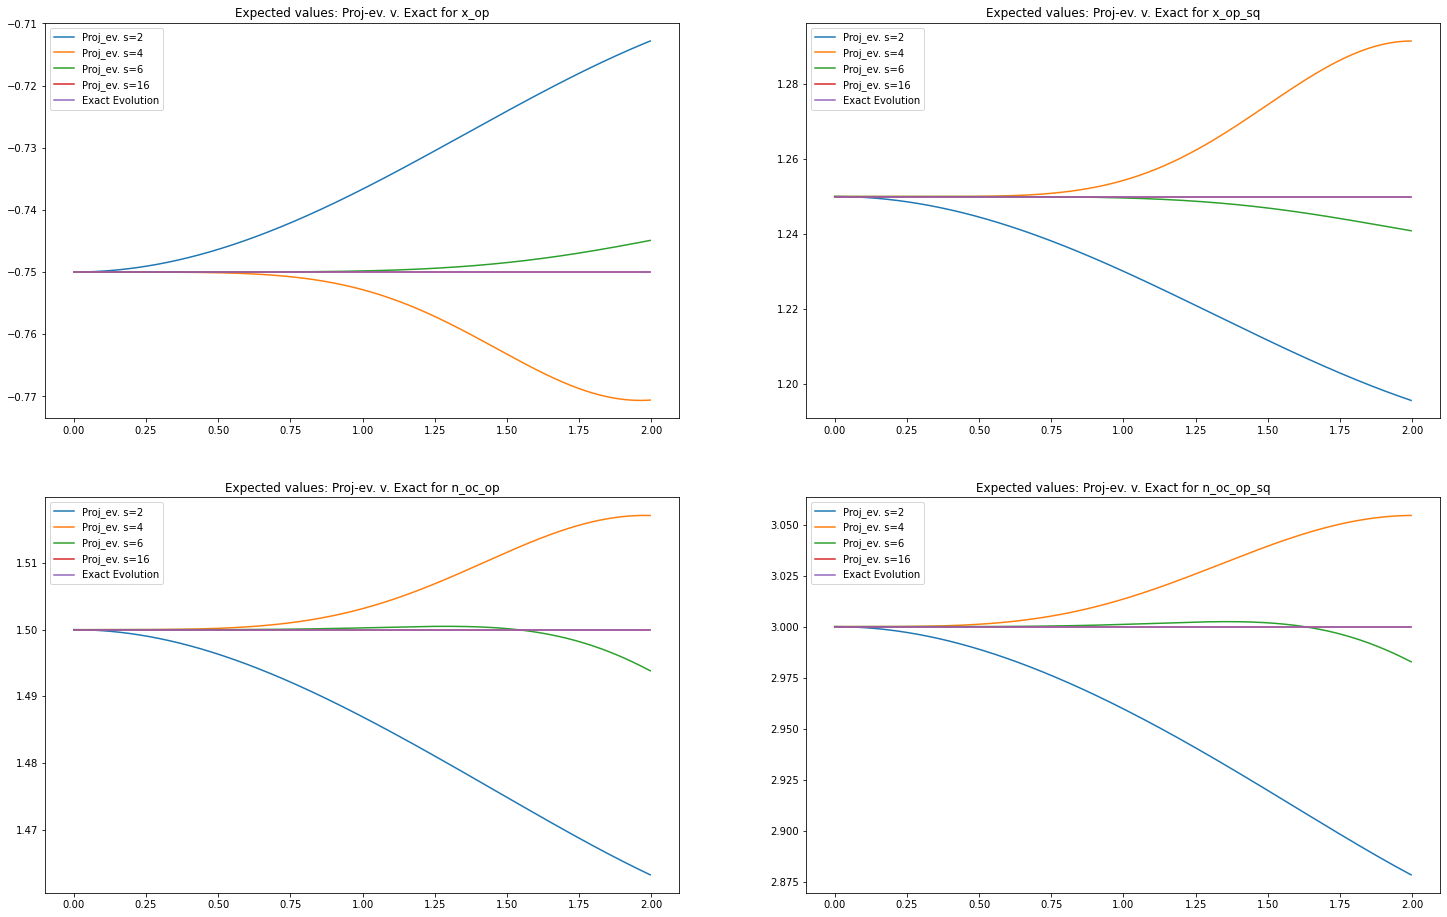

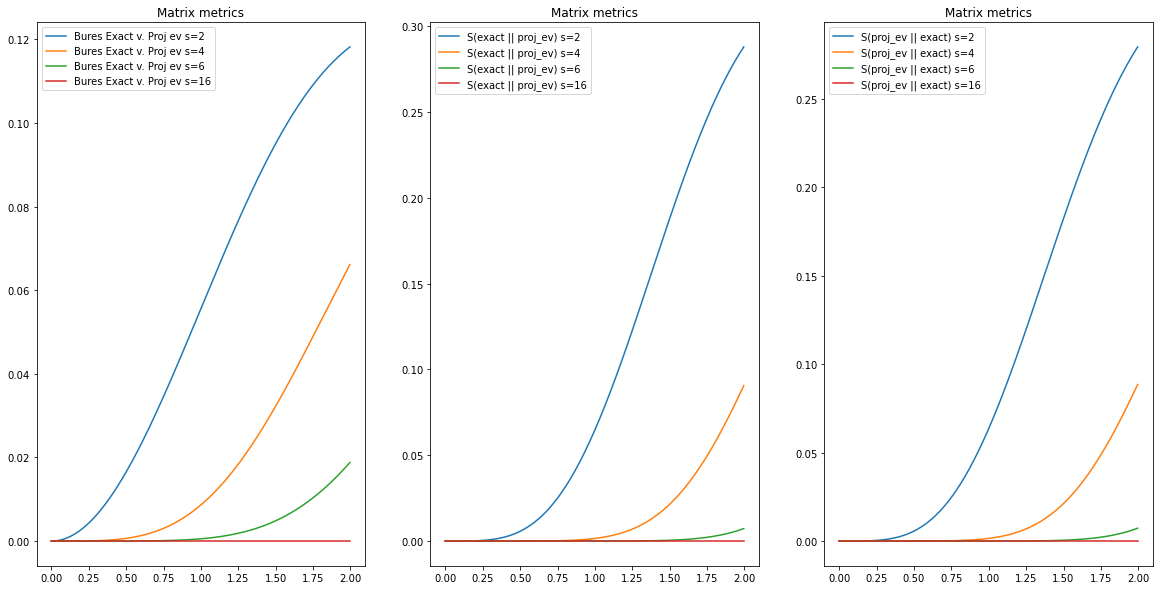

In [38]:
# N = 3, XX
resultados = HBProjEv.HierarchBasis_vardim_proj_evs(Hamiltonian = H_H, rho_ref = custom_rho_ref, 
                                              range_derived_series_orders = range_derived_series_orders, 
                                     temp_ref = temp_ref, temp_rho = temp,
                                     generating_operator = spin_ops_list[1][0],
                                     init_coeff_list = all_coeff_lists,
                                     timespan = ts, label_ops = subset_label_ops,
                                     observables = list(subset_of_observables.values()))

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                                 plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = range_derived_series_orders,
                                                                  multiple_evolutions = resultados,
                                                           plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = range_derived_series_orders,
                                                     metric_local = metrics,
                                                    plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

In [25]:
rho0_ex = resultados["init_configs_all"]["init_configs_HierarchBases3"]["rho0"]
mat_ansys.commutator(rho0_ex, H_H)

resex = qutip.mesolve(H_H, rho0_ex, ts, e_ops = subset_of_observables)
resex.expect

{'x_op': array([-0.749, -0.749, -0.749, ..., -0.749, -0.749, -0.749]),
 'x_op_sq': array([1.249, 1.249, 1.249, ..., 1.249, 1.249, 1.249]),
 'n_oc_op': array([1.5, 1.5, 1.5, ..., 1.5, 1.5, 1.5]),
 'n_oc_op_sq': array([2.999, 2.999, 2.999, ..., 2.999, 2.999, 2.999])}

In [18]:
mat_ansys.commutator(cl_ops["x_op"], H_H)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 -0.785 ... 0.0 0.0 0.0]
 [0.0 0.785 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 -0.785 0.0]
 [0.0 0.0 0.0 ... 0.785 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]

Processing step:  1  and hierarchical basis of l=  0
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  3
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. ProjEv Dynamics Succesfully Concluded.
    |▼| 5b. Exact Dynamics not to be computed. Skipped.
    |▼| 5b. No Plots to process.
    |▼| 6. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of l=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  4
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. ProjEv Dynamics Succesfully Concluded.
    |▼| 5b. Exact Dynamics not to be computed. Skipped.
    |▼| 5b. No Plots to process.
    |▼| 6. Data Stored. Evolutio

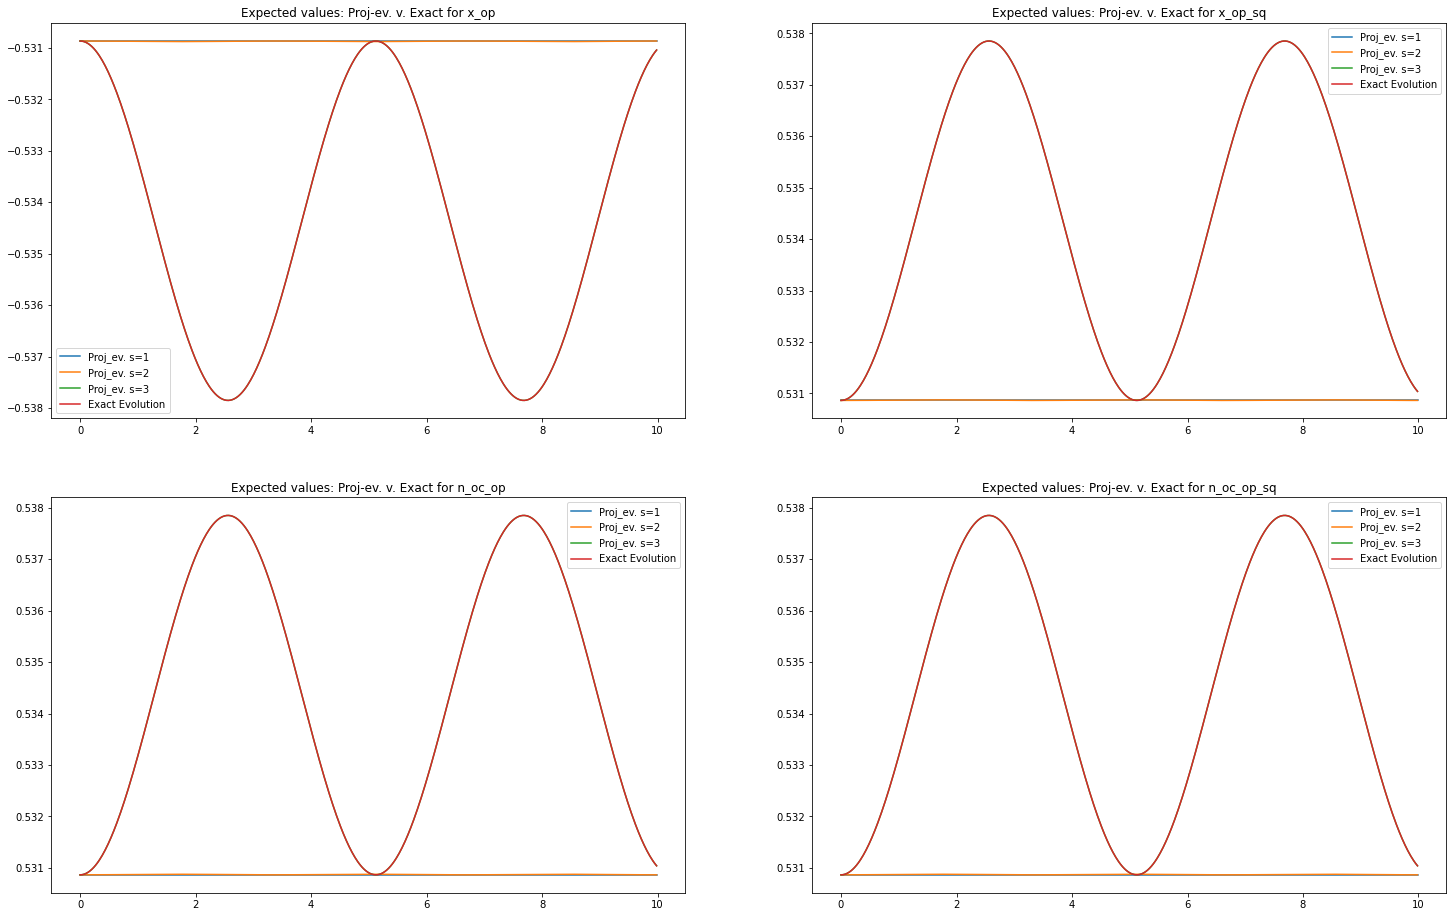

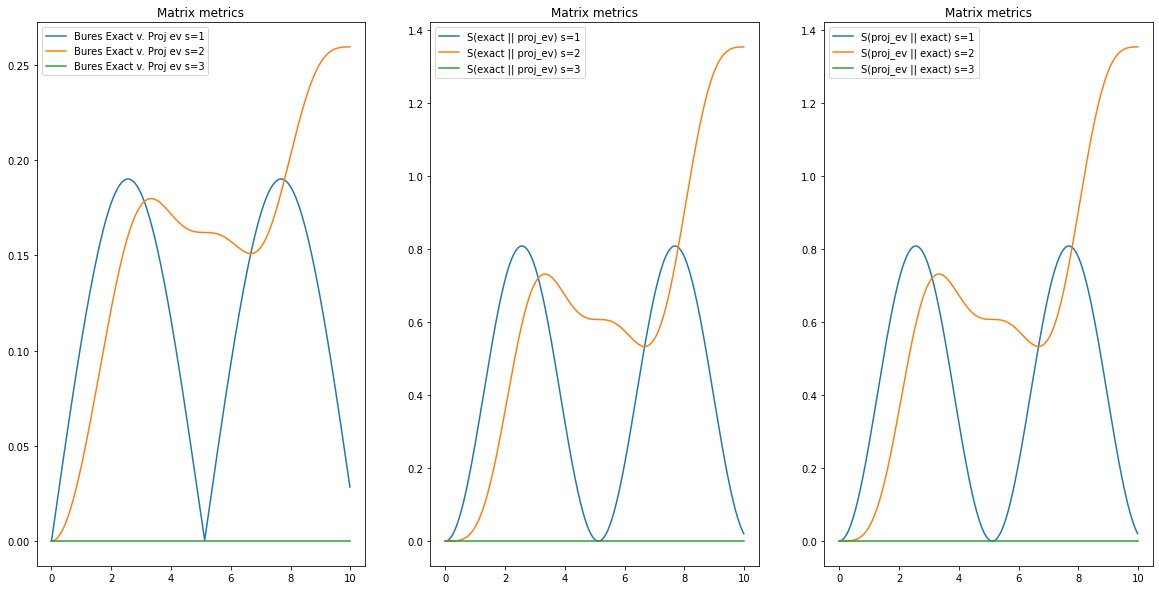

In [7]:
# N = 2, XY
resultados = HBProjEv.HierarchBasis_vardim_proj_evs(Hamiltonian = H_H, rho_ref = custom_rho_ref, 
                                              range_derived_series_orders = range_derived_series_orders, 
                                     temp_ref = temp_ref, temp_rho = temp,
                                     generating_operator = spin_ops_list[1][0],
                                     init_coeff_list = all_coeff_lists,
                                     timespan = ts, label_ops = subset_label_ops,
                                     observables = list(subset_of_observables.values()))

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                                 plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = range_derived_series_orders,
                                                                  multiple_evolutions = resultados,
                                                           plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = range_derived_series_orders,
                                                     metric_local = metrics,
                                                    plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

Processing step:  1  and hierarchical basis of l=  0
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  3
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. ProjEv Dynamics Succesfully Concluded.
    |▼| 5b. Exact Dynamics not to be computed. Skipped.
    |▼| 5b. No Plots to process.
    |▼| 6. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of l=  1
    |▼| 1. Processing reference state ===>
                  c. ^^##^^. custom reference state chosen
    |▼| 2. using a base of size  4
    |▼| 3. Check passed: the basis is orthonormal and hermitian
    |▼| 3b. constructing rho0 from the coeff. list and orth. basis
    |▼| 4. ProjEv Dynamics Succesfully Concluded.
    |▼| 5b. Exact Dynamics not to be computed. Skipped.
    |▼| 5b. No Plots to process.
    |▼| 6. Data Stored. Evolutio

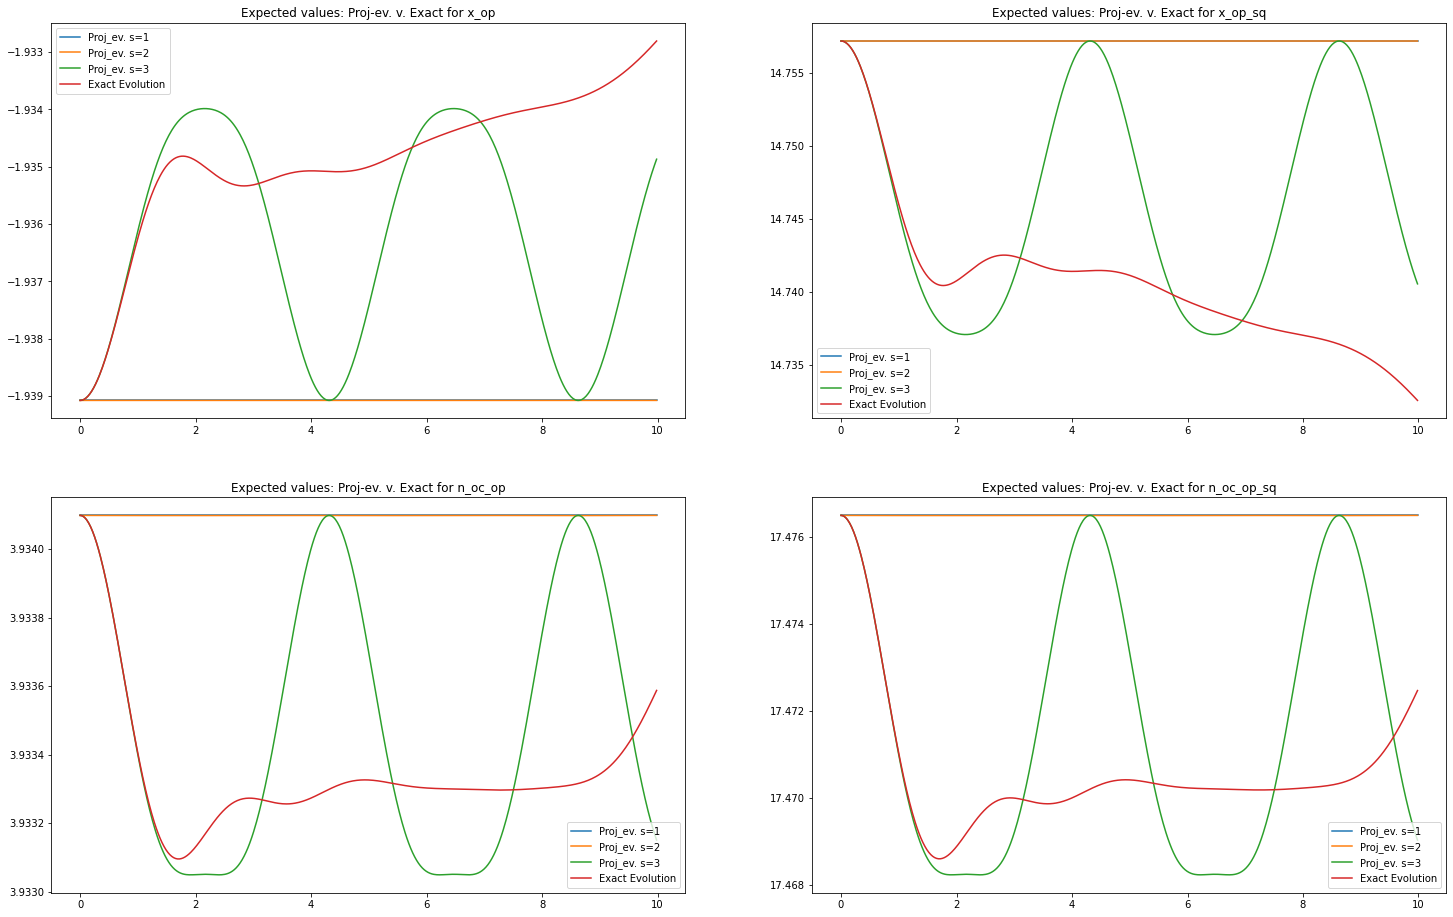

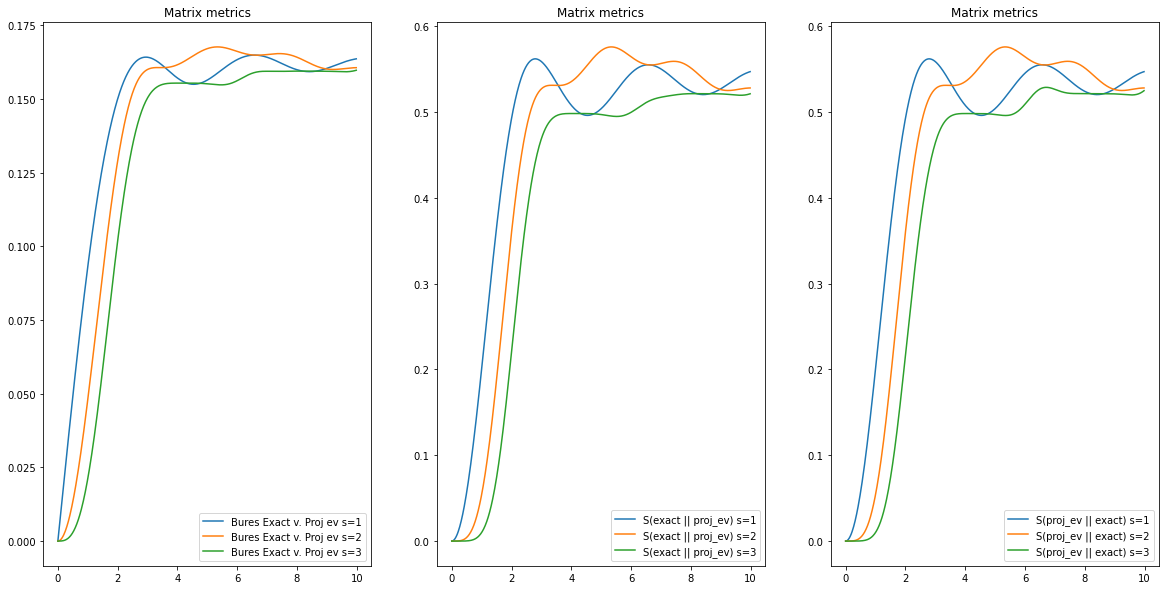

In [17]:
# N = 8
resultados = HBProjEv.HierarchBasis_vardim_proj_evs(Hamiltonian = H_H, rho_ref = custom_rho_ref, 
                                              range_derived_series_orders = range_derived_series_orders, 
                                     temp_ref = temp_ref, temp_rho = temp,
                                     generating_operator = spin_ops_list[1][0],
                                     init_coeff_list = all_coeff_lists,
                                     timespan = ts, label_ops = subset_label_ops,
                                     observables = list(subset_of_observables.values()))

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                                 plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

metrics = mat_ansys.exact_v_proj_ev_matrix_metrics_multiple(timespan = ts,
                                                            range_of_temps_or_dims = range_derived_series_orders,
                                                                  multiple_evolutions = resultados,
                                                           plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)

evs_visz_tools.plot_exact_v_proj_ev_metrics_multiple(timespan = ts,
                                                     range_of_temps_or_dims = range_derived_series_orders,
                                                     metric_local = metrics,
                                                    plot_var_lengths = False,
                                          plot_var_HierarchBases_dim = True,
                                          plot_var_temps = False)